# Lab 5


## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

We used the same dataset that we used in Lab 4.

# Loading and Spliting the dataset 

In [1]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [2]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [3]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


# Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

Tried loading as described https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [4]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (48, 48))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [5]:
print(len(train_images))
print(len(test_images))

24000
6000


# Model Training

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

### 1) Multinomial Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha=1.0e-10, force_alpha=True , class_prior=[0.4, 0.6])
train_labels = train_labels.ravel()
clf1.fit(train_images, train_labels)
predictions1 = clf1.predict(test_images)

##### Model Evaluation


In [8]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(test_labels, predictions1)
print('Accuracy = ', accuracy)

Accuracy =  0.6556666666666666


In [9]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions1)
confusion_matrix

array([[1068, 1932],
       [ 134, 2866]], dtype=int64)

In [10]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1068
FP =  134
TN =  2866
FN =  1932


In [11]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.356
Specificity =  0.9553333333333334


In [12]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_labels, predictions1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions1)
print('Recall = ', recall)

Precision =  0.5973322217590663
Recall =  0.9553333333333334


Area Under Curve =  0.5523554444444445


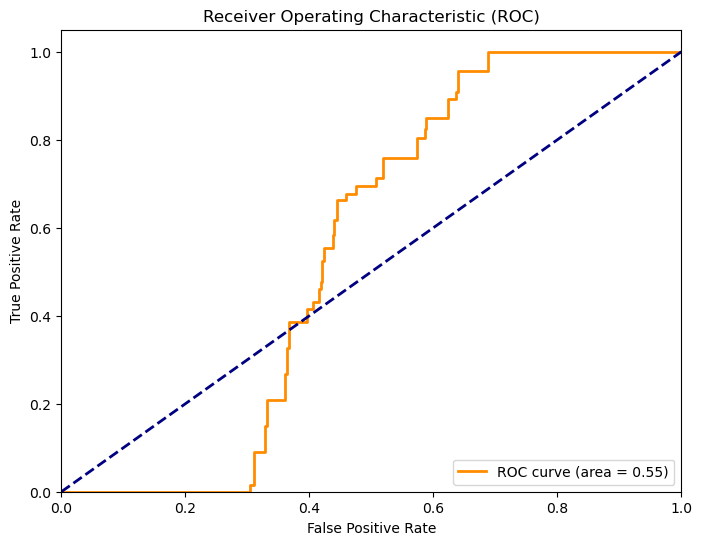

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the positive class
probabilities = clf1.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 2) Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(train_images, train_labels)
predictions2 = clf2.predict(test_images)

##### Model Evaluation


In [15]:
# accuracy
accuracy = accuracy_score(test_labels, predictions2)
print('Accuracy = ', accuracy)

Accuracy =  0.653


In [16]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions2)
confusion_matrix

array([[2316,  684],
       [1398, 1602]], dtype=int64)

In [17]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  2316
FP =  1398
TN =  1602
FN =  684


In [18]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.772
Specificity =  0.534


In [19]:
precision = precision_score(test_labels, predictions2)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions2)
print('Recall = ', recall)

Precision =  0.7007874015748031
Recall =  0.534


Area Under Curve =  0.782322


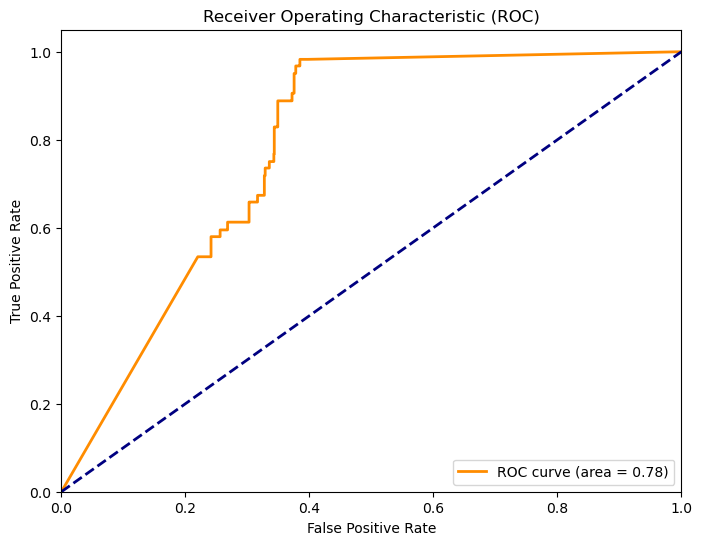

In [20]:
# Calculate predicted probabilities for the positive class
probabilities = clf2.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 3) Complement Naive Bayes

In [21]:
from sklearn.naive_bayes import ComplementNB
clf3 = ComplementNB(force_alpha=True)
clf3.fit(train_images, train_labels)
predictions3 = clf3.predict(test_images)

##### Model Evaluation


In [22]:
# accuracy
accuracy = accuracy_score(test_labels, predictions3)
print('Accuracy = ', accuracy)

Accuracy =  0.601


In [23]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions3)
confusion_matrix

array([[1331, 1669],
       [ 725, 2275]], dtype=int64)

In [24]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1331
FP =  725
TN =  2275
FN =  1669


In [25]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.44366666666666665
Specificity =  0.7583333333333333


In [26]:
precision = precision_score(test_labels, predictions3)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions3)
print('Recall = ', recall)

Precision =  0.5768255578093306
Recall =  0.7583333333333333


Area Under Curve =  0.552383888888889


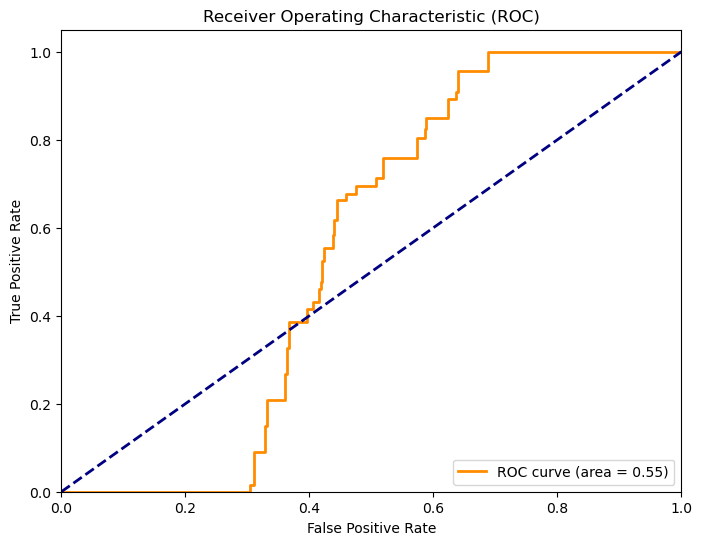

In [27]:
# Calculate predicted probabilities for the positive class
probabilities = clf3.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 4) Bernoulli Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB
clf4 = BernoulliNB(force_alpha=True)
clf4.fit(train_images, train_labels)
predictions4 = clf4.predict(test_images)

##### Model Evaluation


In [29]:
# accuracy
accuracy = accuracy_score(test_labels, predictions4)
print('Accuracy = ', accuracy)

Accuracy =  0.5


In [30]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions4)
confusion_matrix

array([[3000,    0],
       [3000,    0]], dtype=int64)

In [31]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  3000
FP =  3000
TN =  0
FN =  0


In [32]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  1.0
Specificity =  0.0


In [33]:
precision = precision_score(test_labels, predictions4, zero_division=1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions4, zero_division=1)
print('Recall = ', recall)

Precision =  1.0
Recall =  0.0


Area Under Curve =  0.5


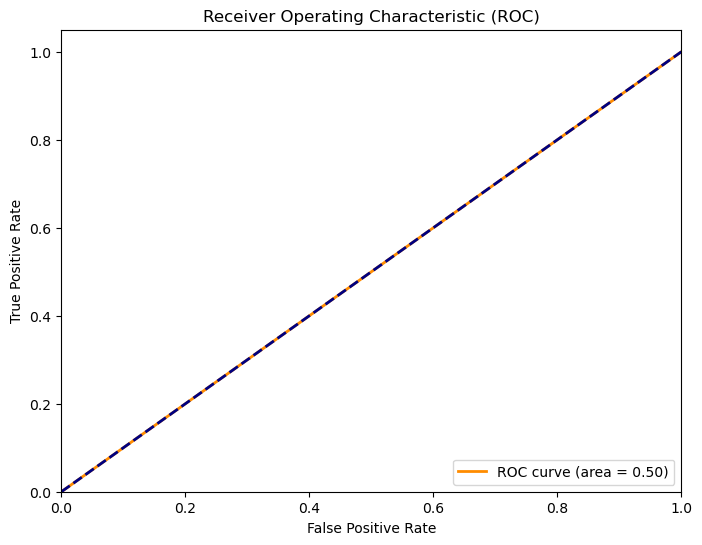

In [34]:
# Calculate predicted probabilities for the positive class
probabilities = clf4.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 5) Categorical Naive Bayes

In [35]:
from sklearn.naive_bayes import CategoricalNB
clf5 = CategoricalNB(force_alpha=True)
clf5.fit(train_images, train_labels)
predictions5 = clf5.predict(test_images)

##### Model Evaluation


In [36]:
# accuracy
accuracy = accuracy_score(test_labels, predictions5)
print('Accuracy = ', accuracy)

Accuracy =  0.6163333333333333


In [37]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions5)
confusion_matrix

array([[ 698, 2302],
       [   0, 3000]], dtype=int64)

In [38]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  698
FP =  0
TN =  3000
FN =  2302


In [39]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.23266666666666666
Specificity =  1.0


In [40]:
precision = precision_score(test_labels, predictions5)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions5)
print('Recall = ', recall)

Precision =  0.5658242172764995
Recall =  1.0


Area Under Curve =  0.6285


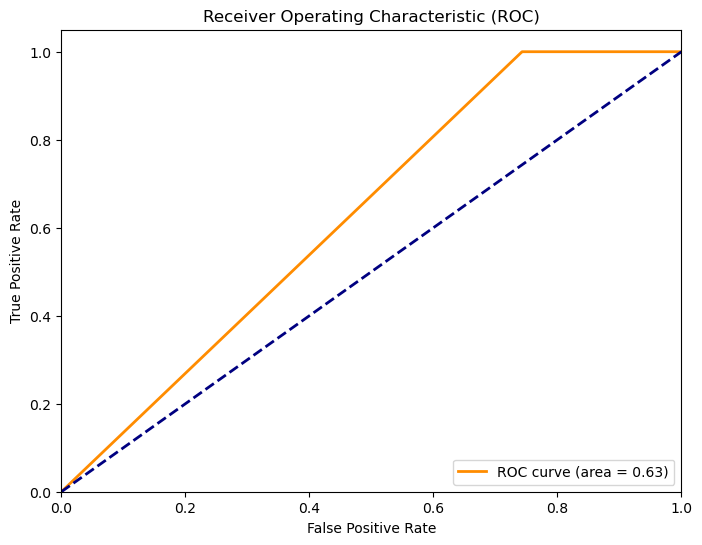

In [41]:
# Calculate predicted probabilities for the positive class
probabilities = clf5.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Clustering


## Optimal number of clusters

In [42]:
X=test_images
y=test_labels

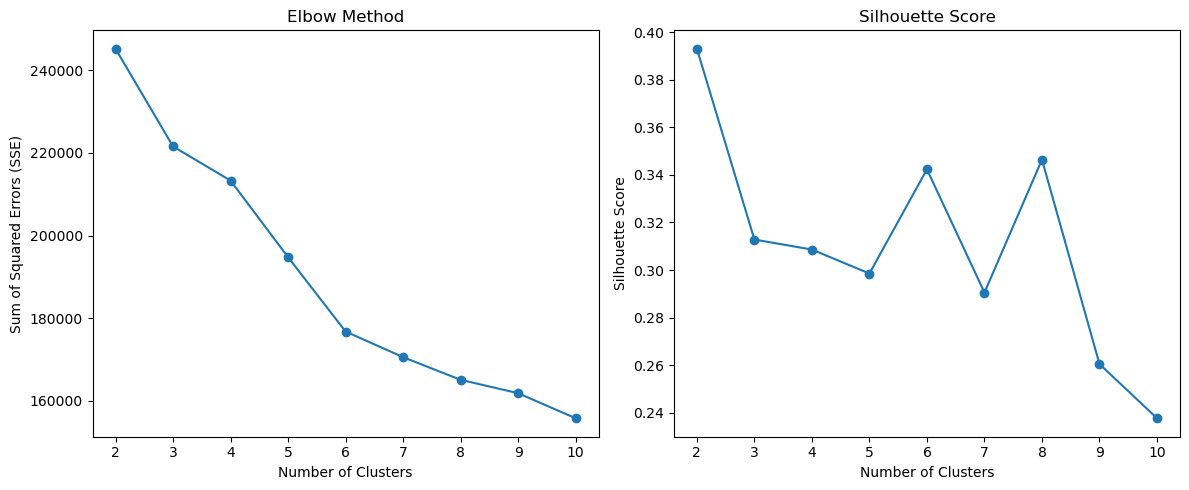

In [43]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

cluster_range = range(2, 11)
sse = []  
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

No clear Elbow is found.
Highest silhouette score is at 2 clusters, this makes sense since there are 2 classes in this dataset; Healthy and Miner (Domain knowledge).

## Evaluation

In [44]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

k_clusters=2

algorithms = [
    ('GaussianMixture', GaussianMixture(n_components=k_clusters)),
    ('KMeans', KMeans(n_clusters=k_clusters, n_init="auto")),
    ('MiniBatchKMeans', MiniBatchKMeans(n_clusters=k_clusters, batch_size=1536 , init='k-means++', n_init=50)), 
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=k_clusters))
]

In [45]:
import pandas as pd
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    fpr= TP / (TP + FN)
    tpr= Sensitivity
    silhouette_scores = silhouette_score(X, y_pred)
    F1_score = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    Precision = precision_score(y, y_pred)
    Recall = recall_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_scores

def evaluate_unsupervised(algorithms,X):
    results = []
    for name, algorithm in algorithms:
        cluster_labels = algorithm.fit_predict(X)
        fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_score_ = calculate_metrics(y, cluster_labels)
        print(name,' Done')
        results.append({
            'Algorithm': name,
            'Silhouette Score': silhouette_score_,
            'TPR': tpr,
            'FPR': fpr,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'Sensitivity': Sensitivity,
            'Specificity': Specificity,
            'Precision': Precision,
            'Recall': Recall,
            'ROC_AUC': roc_auc,
            'Accuracy': accuracy,
            'F1-Score': F1_score,
            'algorithm': algorithm
        })
    return pd.DataFrame(results)

In [46]:
calculate_metrics(y,clf2.predict(X))

(0.534,
 0.534,
 1602,
 684,
 2316,
 1398,
 0.534,
 0.772,
 0.7007874015748031,
 0.534,
 0.653,
 0.653,
 0.6061293984108969,
 0.37759445895457006)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [49]:
results_df_full_feature = evaluate_unsupervised(algorithms,X)
results_df_full_feature


GaussianMixture  Done
KMeans  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,algorithm
0,GaussianMixture,0.392455,0.466,0.466,1398,2169,831,1602,0.466,0.277000,0.391926,0.466,0.371500,0.371500,0.425765,GaussianMixture(n_components=2)
1,KMeans,0.393016,0.534,0.534,1602,803,2197,1398,0.534,0.732333,0.666112,0.534,0.633167,0.633167,0.592784,"KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.393016,0.466,0.466,1398,2197,803,1602,0.466,0.267667,0.388873,0.466,0.366833,0.366833,0.423958,"MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.383456,0.534,0.534,1602,515,2485,1398,0.534,0.828333,0.756731,0.534,0.681167,0.681167,0.626148,AgglomerativeClustering()


https://github.com/scikit-learn/scikit-learn/blob/main/examples/mixture/plot_gmm_pdf.py

In [50]:
def scatterPlot(df, data_2d):
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))
    num_clusters = 2

    for index, row in df.iterrows():
        if row['Algorithm'] != "GaussianMixture":
            algorithm_name = row['Algorithm']
            silhouette_score = row['Silhouette Score']
            algorithm = row['algorithm']

            ax = axes[index - 1]
            for i in range(num_clusters):
                ax.scatter(data_2d[algorithm.labels_ == i, 0], data_2d[algorithm.labels_ == i, 1], label=f'Cluster {i}')

            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            ax.set_title(f'{algorithm_name}  (Silhouette Score: {round(silhouette_score, 3)})')
            ax.legend()

    fig.suptitle('t-SNE Clustering with Decision Boundaries')
    plt.show()


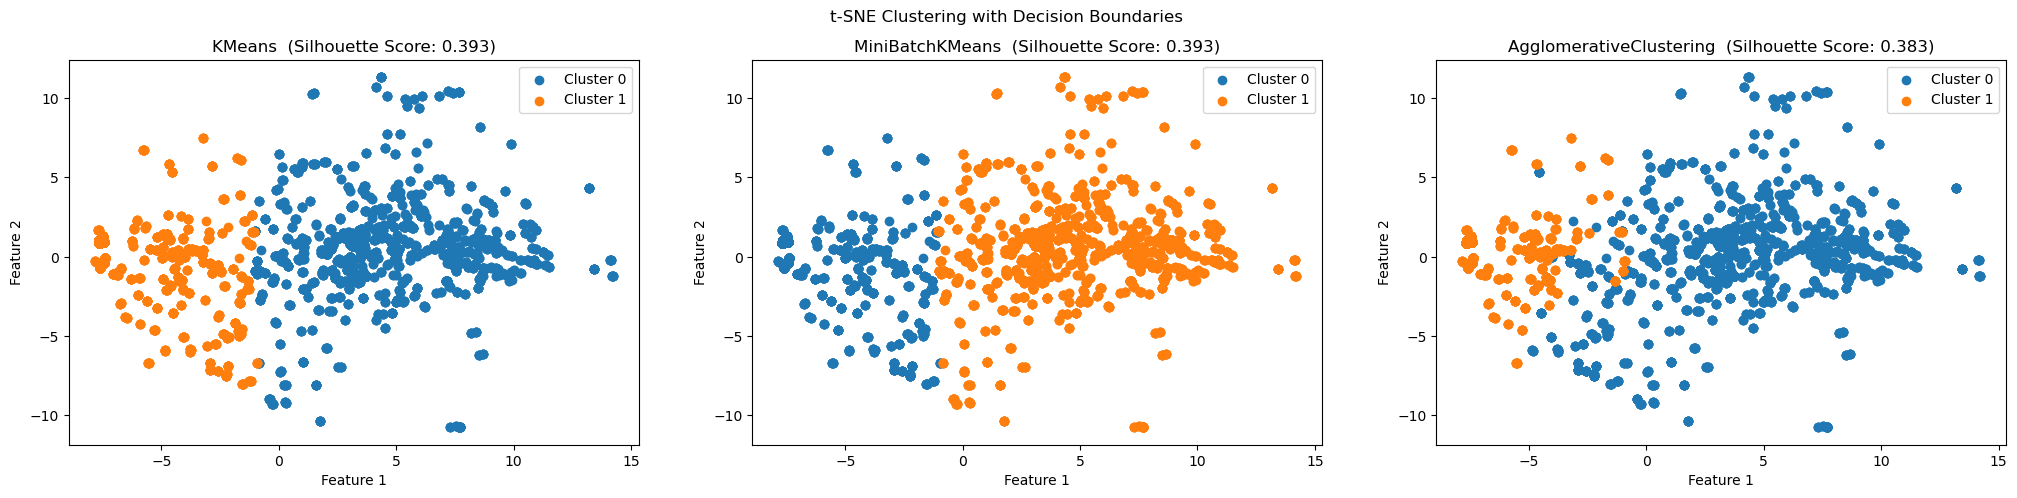

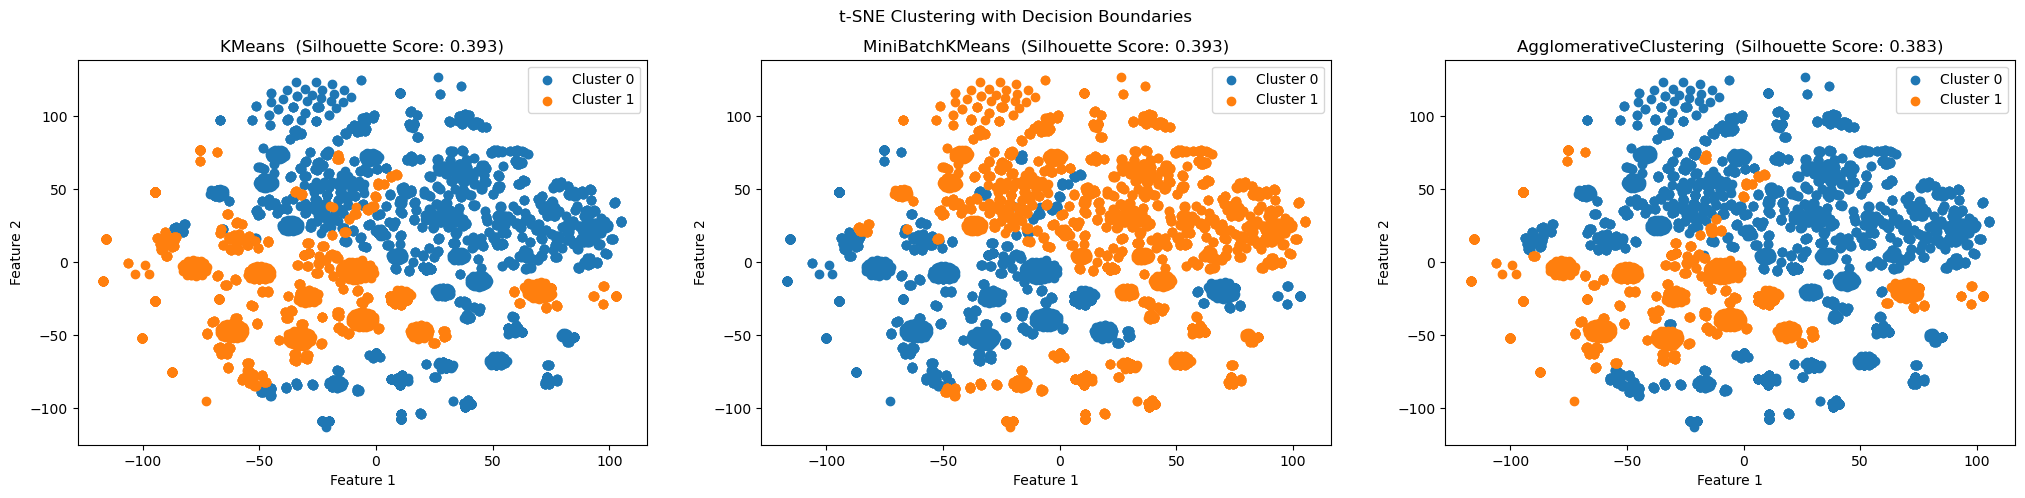

In [51]:
scatterPlot(results_df_full_feature,X_pca)
scatterPlot(results_df_full_feature,X_tsne)

In [52]:
results_df_2PCA= evaluate_unsupervised(algorithms,X_pca)
results_df_2PCA

GaussianMixture  Done
KMeans  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,algorithm
0,GaussianMixture,0.336431,0.534,0.534,1602,24,2976,1398,0.534,0.992000,0.985240,0.534,0.763000,0.763000,0.692607,GaussianMixture(n_components=2)
1,KMeans,0.393031,0.466,0.466,1398,2205,795,1602,0.466,0.265000,0.388010,0.466,0.365500,0.365500,0.423444,"KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.393031,0.534,0.534,1602,795,2205,1398,0.534,0.735000,0.668335,0.534,0.634500,0.634500,0.593663,"MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.384317,0.534,0.534,1602,506,2494,1398,0.534,0.831333,0.759962,0.534,0.682667,0.682667,0.627251,AgglomerativeClustering()


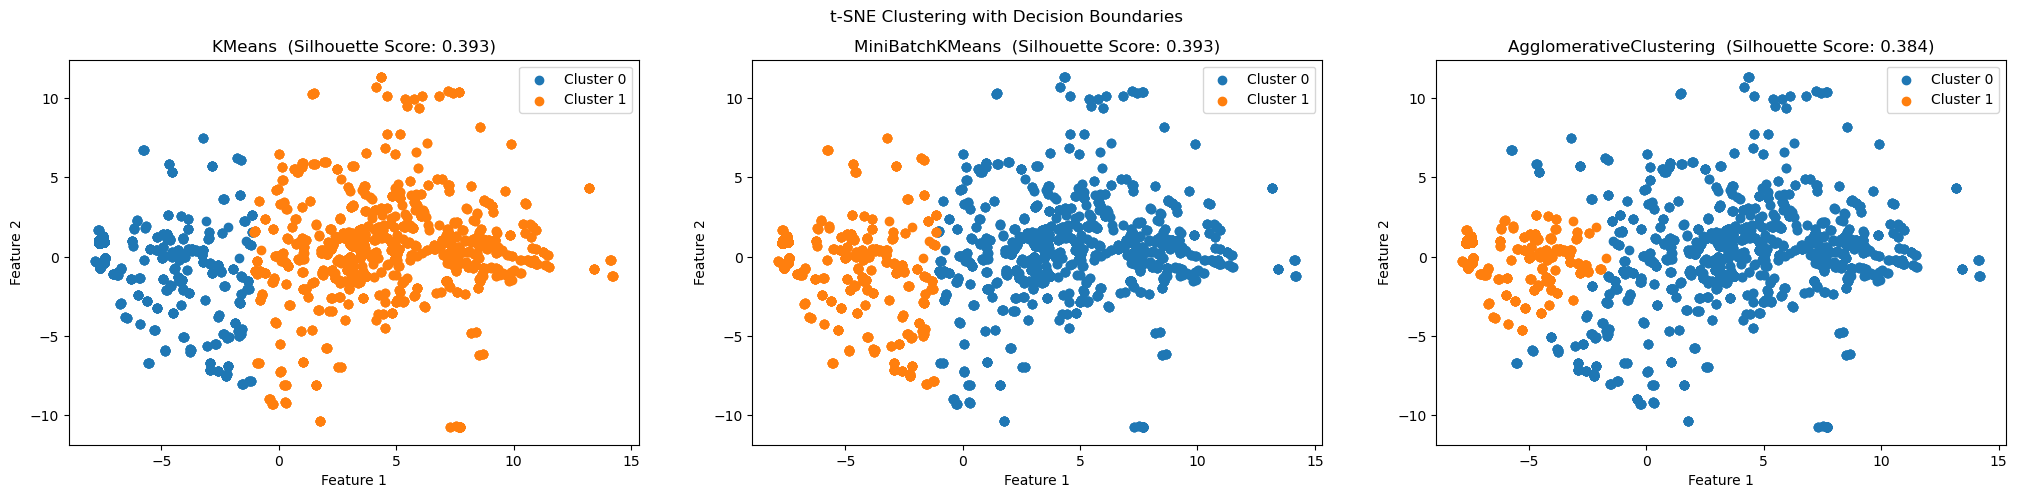

In [53]:
scatterPlot(results_df_2PCA,X_pca)

In [54]:
results_df_2tsne = evaluate_unsupervised(algorithms,X_tsne)
results_df_2tsne

GaussianMixture  Done
KMeans  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,algorithm
0,GaussianMixture,0.112985,0.545000,0.545000,1635,1350,1650,1365,0.545000,0.550000,0.547739,0.545000,0.547500,0.547500,0.546366,GaussianMixture(n_components=2)
1,KMeans,0.190528,0.712333,0.712333,2137,888,2112,863,0.712333,0.704000,0.706446,0.712333,0.708167,0.708167,0.709378,"KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.164315,0.292333,0.292333,877,2098,902,2123,0.292333,0.300667,0.294790,0.292333,0.296500,0.296500,0.293556,"MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.142177,0.237333,0.237333,712,2059,941,2288,0.237333,0.313667,0.256947,0.237333,0.275500,0.275500,0.246751,AgglomerativeClustering()


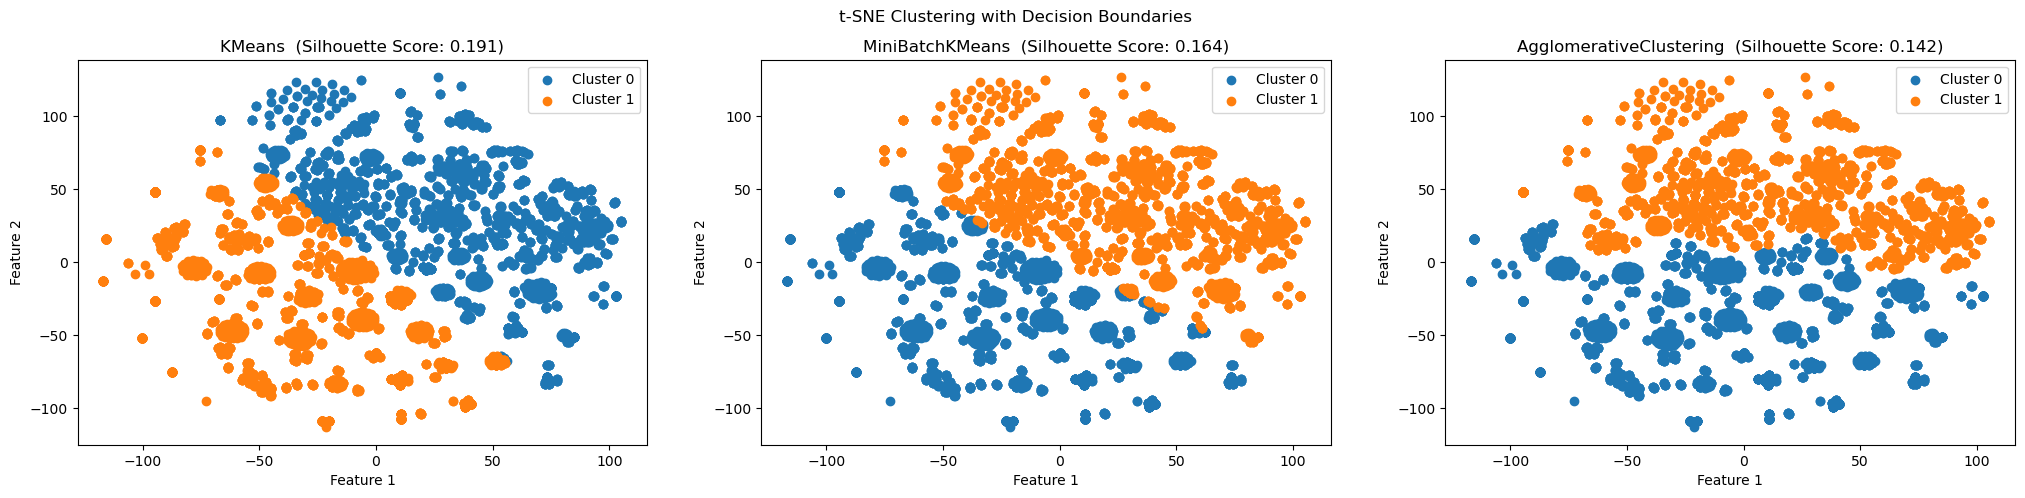

In [55]:
scatterPlot(results_df_2tsne,X_tsne)